# Proyek Klasifikasi Gambar: Animals-10 Dataset
Di sel Markdown ini, cukup isi data diri Anda:

Nama: Riski Putra Alamzah

Email: riskialamzah1@gmail.com

ID Dicoding: riskiputraalamzah



## Import Semua Packages/Library yang Digunakan

In [1]:
# Install semua library yang dibutuhkan
!pip install tensorflow
!pip install datasets
!pip install tensorflowjs


import requests
from PIL import Image
import io

# --- Import fungsi preprocessing yang benar untuk EfficientNetV2 ---
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras import regularizers, optimizers, applications

# Import library utama
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

# Import untuk data loading dan evaluasi
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix

# Import untuk konversi model
import tensorflowjs as tfjs

# Set random seed untuk hasil yang konsisten
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print('✅ Berhasil terhubung ke TPU!')
  print('Semua perangkat:', tf.config.list_logical_devices('TPU'))
except ValueError:
  print('❌ Gagal terhubung ke TPU. Coba ganti ke GPU atau restart sesi lagi.')

!nvidia-smi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 re

2025-09-06 15:17:32.928129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757171853.145050      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757171853.207734      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.8.0
❌ Gagal terhubung ke TPU. Coba ganti ke GPU atau restart sesi lagi.
Sat Sep  6 15:17:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       1MiB /  15360MiB |      0%      Default |
|                       

In [2]:
!rm -rf submission best_model.keras submission.zip transfer_learning_best.keras
# HAPUS CACHE LAMA UNTUK MENGHINDARI KONFLIK
!rm -rf ./train_cache ./val_cache ./test_cache


## Data Preparation


### Data Loading
Di sel ini, kita akan fokus hanya untuk mengunduh dan menyimpan dataset ke direktori lokal.

In [3]:
# Menggunakan library datasets dari Hugging Face untuk mengunduh
dataset_dir = "./animals10/raw-img"

# Cek apakah dataset sudah ada, jika belum maka unduh dan simpan
if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
    print("Dataset tidak ditemukan. Mengunduh dan menyimpan...")
    try:
        # Unduh dataset dari Hugging Face
        dataset = load_dataset("Rapidata/Animals-10", split="train")
        print("Dataset berhasil diunduh!")

        label_to_name = dataset.features['label'].int2str

        # Simpan gambar ke dalam struktur folder per kelas
        os.makedirs(dataset_dir, exist_ok=True)
        for item in dataset:
            class_name = label_to_name(item['label'])
            image = item['image']
            class_dir = os.path.join(dataset_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)

            # Buat nama file unik untuk menghindari tumpang tindih
            filename = f"image_{len(os.listdir(class_dir))}.jpg"
            image_path = os.path.join(class_dir, filename)
            image.save(image_path)

        print("Gambar berhasil disimpan ke direktori lokal.")
    except Exception as e:
        print(f"\nTerjadi error saat mengunduh: {e}")
else:
    print("Dataset sudah ada di direktori lokal. Melewati proses unduh.")

# Analisis singkat jumlah gambar
total_images = sum([len(files) for r, d, files in os.walk(dataset_dir)])
class_names_list = sorted(os.listdir(dataset_dir))
print(f"\nTotal gambar dalam dataset: {total_images}")
print(f"Jumlah kelas: {len(class_names_list)}")
print("Nama kelas:", class_names_list)

Dataset tidak ditemukan. Mengunduh dan menyimpan...


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/319M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23554 [00:00<?, ? examples/s]

Dataset berhasil diunduh!
Gambar berhasil disimpan ke direktori lokal.

Total gambar dalam dataset: 23554
Jumlah kelas: 10
Nama kelas: ['Butterfly', 'Cat', 'Chicken', 'Cow', 'Dog', 'Elephant', 'Horse', 'Sheep', 'Spider', 'Squirrel']


## Data Preprocessing

#### Split Dataset


In [4]:
# ======================================================================
# BLOK KODE PERSIAPAN DATA BARU (GANTIKAN SEMUA SEL LAMA)
# ======================================================================
import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

# --- Konfigurasi --
BATCH_SIZE = 32
IMG_SIZE = (150, 150)
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# --- 1. Kumpulkan semua path file gambar dan labelnya ---
print("Mengumpulkan path file gambar...")
dataset_dir = "./animals10/raw-img"
image_paths = list(glob.glob(f'{dataset_dir}/*/*.jpg'))
class_names = sorted(os.listdir(dataset_dir))
label_map = {name: i for i, name in enumerate(class_names)}
labels = [label_map[os.path.basename(os.path.dirname(path))] for path in image_paths]
print(f"Ditemukan {len(image_paths)} gambar dalam {len(class_names)} kelas.")

# --- 2. Bagi path file menjadi train (80%) dan sisa (20%) ---
print("Membagi dataset menjadi 80% train, 10% validation, 10% test...")
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
)

# --- 3. Bagi sisa (20%) menjadi validation (10%) dan test (10%) ---
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=SEED, stratify=temp_labels
)

print(f"Ukuran set training: {len(train_paths)}")
print(f"Ukuran set validasi: {len(val_paths)}")
print(f"Ukuran set testing: {len(test_paths)}")

# --- 4. Buat fungsi untuk memuat dan memproses gambar dari path ---
def process_path(path, label):
    # Baca file
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize
    img = tf.image.resize(img, IMG_SIZE)
    # Ubah label menjadi categorical
    label = tf.one_hot(label, len(class_names))
    return img, label

# --- 5. Buat tf.data.Dataset dari path yang sudah dibagi ---
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# --- 6. Terapkan pemrosesan dan optimasi ke setiap dataset ---
print("\nMenerapkan pemrosesan dan optimasi pipeline data...")
# Hapus cache lama untuk memastikan tidak ada konflik
!rm -rf ./train_cache ./val_cache ./test_cache

# --- Augmentasi Data (dipisahkan agar bisa diterapkan sebelum preprocessing) ---
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name='augmentation')

# Pipeline untuk Training Set
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache('./train_cache').shuffle(1000).batch(BATCH_SIZE)
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE) # <-- TAMBAHKAN INI
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)


# Pipeline untuk Validation Set
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache('./val_cache').batch(BATCH_SIZE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE) # <-- TAMBAHKAN INI
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Pipeline untuk Test Set
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache('./test_cache').batch(BATCH_SIZE)
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE) # <-- TAMBAHKAN INI
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("\n✅ Setup dataset dengan preprocessing yang benar telah selesai.")

Mengumpulkan path file gambar...
Ditemukan 23554 gambar dalam 10 kelas.
Membagi dataset menjadi 80% train, 10% validation, 10% test...
Ukuran set training: 18843
Ukuran set validasi: 2355
Ukuran set testing: 2356

Menerapkan pemrosesan dan optimasi pipeline data...


I0000 00:00:1757171916.844107      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757171916.844855      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



✅ Setup dataset dengan preprocessing yang benar telah selesai.


## Modelling

In [5]:
# ======================================================================
# KODE MODELLING BARU SESUAI KRITERIA REVIEWER
# ======================================================================

# --- 1. Fungsi untuk Membuat Model SEQUENTIAL dengan Layer Wajib ---
def create_sequential_model(input_shape, num_classes):
    # Load pre-trained model EfficientNetV2B0 sebagai base model.
    # PENTING:
    # 1. include_top=False -> Untuk mengambil model tanpa layer Dense teratas.
    # 2. pooling='avg' DIHAPUS -> Agar outputnya masih berupa feature map (misal: 5x5x1280),
    #    sehingga kita bisa menambahkan layer Conv2D & Pooling di atasnya.
    base_model = applications.EfficientNetV2B0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    # Bekukan base_model agar bobotnya tidak berubah saat training tahap pertama
    base_model.trainable = False

    # --- MEMBUAT MODEL SEQUENTIAL ---
    model = tf.keras.Sequential([
        # Layer 1: Base model transfer learning
        base_model,

        # Layer 2: Conv2D (KRITERIA WAJIB)
        # Menambahkan layer konvolusi untuk mengekstrak fitur lebih lanjut.
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Layer 3: Pooling Layer (KRITERIA WAJIB)
        # Menggunakan MaxPooling untuk mengurangi dimensi.
        layers.MaxPooling2D(),

        # Layer 4: Flatten
        # Mengubah feature map menjadi vektor 1D untuk diumpankan ke layer Dense.
        layers.Flatten(),

        # Layer 5: Dropout untuk mengurangi overfitting
        layers.Dropout(0.5),

        # Layer 6: Output Layer
        # Layer Dense dengan aktivasi softmax untuk klasifikasi multi-kelas.
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

# --- 2. Menyiapkan Strategi dan Membuat Model ---
strategy = tf.distribute.get_strategy()
print(f'Menggunakan strategi: {strategy.__class__.__name__}')

with strategy.scope():
    input_shape = IMG_SIZE + (3,)
    num_classes = len(class_names)
    # Panggil fungsi baru untuk membuat model sequential
    model, base_model = create_sequential_model(input_shape, num_classes)

    # Kompilasi awal untuk tahap feature extraction
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# Tampilkan ringkasan arsitektur model baru
model.summary()

# --- 3. Callbacks (Sama seperti sebelumnya, tidak perlu diubah) ---
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='transfer_learning_best.keras', monitor='val_accuracy', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
]

# --- 4. Training Model (Tahap 1 & 2) ---
# Dataset train_ds sudah memiliki augmentasi dari sel sebelumnya
if model:
    print("\nMemulai training Tahap 1 (Feature Extraction)...")
    history_extraction = model.fit(
        train_ds,
        epochs=20,          # Tetap gunakan 20 epoch, EarlyStopping akan berhenti jika perlu
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )

    print("\nMemulai training Tahap 2 (Fine-Tuning)...")
    # Buka sebagian layer dari base_model agar bisa dilatih (fine-tuning)
    base_model.trainable = True

    # Kompilasi ulang model dengan learning rate yang sangat kecil untuk fine-tuning
    with strategy.scope():
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-5),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    history_finetune = model.fit(
        train_ds,
        epochs=20,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=1
    )
    print("\nTraining selesai!")

Menggunakan strategi: _DefaultDistributionStrategy
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 5, 5, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 3, 3, 64)       │       737,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,657,306 (25.40 MB)

 Trainable params: 737,994 (2.82 MB)

 Non-trainable params: 5,919,312 (22.58 MB)


Memulai training Tahap 1 (Feature Extraction)...
Epoch 1/20


I0000 00:00:1757171939.035734     130 service.cc:148] XLA service 0x77fe940b87b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757171939.036358     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757171939.036377     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757171941.064543     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/589 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.1758 - loss: 3.9926 

I0000 00:00:1757171952.128191     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


589/589 ━━━━━━━━━━━━━━━━━━━━ 96s 112ms/step - accuracy: 0.7091 - loss: 1.0383 - val_accuracy: 0.9427 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 36s 61ms/step - accuracy: 0.8054 - loss: 0.6607 - val_accuracy: 0.9580 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.8212 - loss: 0.5804 - val_accuracy: 0.9588 - val_loss: 0.1485 - learning_rate: 0.0010
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.8346 - loss: 0.5180 - val_accuracy: 0.9597 - val_loss: 0.1472 - learning_rate: 0.0010
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.8431 - loss: 0.4874 - val_accuracy: 0.9571 - val_loss: 0.1488 - learning_rate: 0.0010
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.8413 - loss: 0.4963 - val_accuracy: 0.9686 - val_loss: 0.1247 - learning_rate: 0.0010
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.8532 - loss: 0.457

E0000 00:00:1757172768.273818     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757172768.409989     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


588/589 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7592 - loss: 1.0729

E0000 00:00:1757172845.614315     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757172845.750167     127 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


589/589 ━━━━━━━━━━━━━━━━━━━━ 185s 149ms/step - accuracy: 0.7593 - loss: 1.0725 - val_accuracy: 0.9108 - val_loss: 0.3360 - learning_rate: 1.0000e-05
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.8107 - loss: 0.6624 - val_accuracy: 0.9257 - val_loss: 0.2758 - learning_rate: 1.0000e-05
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.8290 - loss: 0.5620 - val_accuracy: 0.9363 - val_loss: 0.2281 - learning_rate: 1.0000e-05
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.8476 - loss: 0.4963 - val_accuracy: 0.9393 - val_loss: 0.2082 - learning_rate: 1.0000e-05
Epoch 5/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 44s 75ms/step - accuracy: 0.8611 - loss: 0.4570 - val_accuracy: 0.9482 - val_loss: 0.1894 - learning_rate: 1.0000e-05
Epoch 6/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.8622 - loss: 0.4315 - val_accuracy: 0.9512 - val_loss: 0.1688 - learning_rate: 1.0000e-05
Epoch 7/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accur

## Evaluasi dan Visualisasi
Sel ini akan menampilkan plot akurasi/loss, laporan klasifikasi, dan confusion matrix.

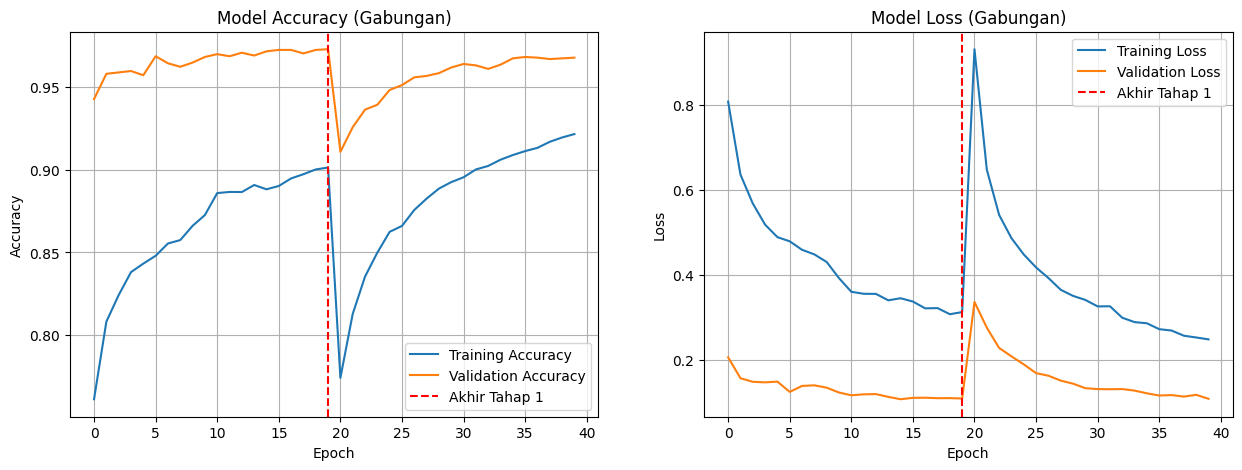


Evaluasi model pada test set...
Test Accuracy: 95.67%

Membuat laporan klasifikasi dan confusion matrix...

Laporan Klasifikasi:
               precision    recall  f1-score   support

   Butterfly       0.95      0.97      0.96       161
         Cat       0.97      0.93      0.94       120
     Chicken       0.95      0.98      0.97       300
         Cow       0.90      0.88      0.89       180
         Dog       0.97      0.94      0.95       481
    Elephant       0.96      0.99      0.98       103
       Horse       0.95      0.97      0.96       260
       Sheep       0.89      0.93      0.91       137
      Spider       0.99      0.98      0.98       434
    Squirrel       0.98      0.96      0.97       180

    accuracy                           0.96      2356
   macro avg       0.95      0.95      0.95      2356
weighted avg       0.96      0.96      0.96      2356



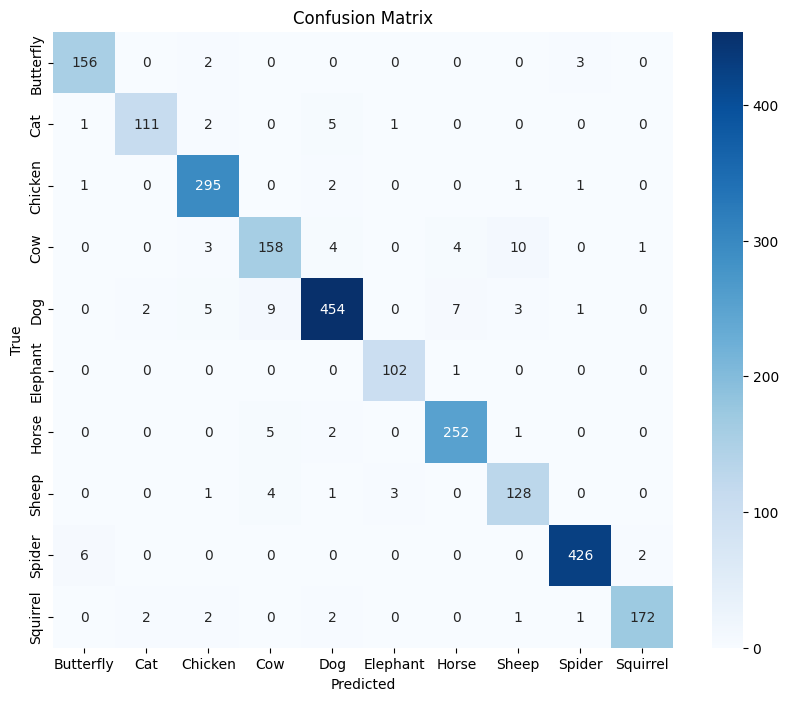

In [6]:
# Inisialisasi dictionary history gabungan
history_dict = {}

# Gabungkan metrik dari kedua history
for key in history_extraction.history.keys():
    history_dict[key] = history_extraction.history[key] + history_finetune.history[key]

# --- 2. Plot Akurasi dan Loss dari History Gabungan ---
plt.figure(figsize=(15, 5))
# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.axvline(len(history_extraction.history['accuracy']) - 1, color='r', linestyle='--', label='Akhir Tahap 1') # Penanda
plt.title('Model Accuracy (Gabungan)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.axvline(len(history_extraction.history['loss']) - 1, color='r', linestyle='--', label='Akhir Tahap 1') # Penanda
plt.title('Model Loss (Gabungan)')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()

# --- 3. Evaluasi pada Test Set ---
# 'EarlyStopping' sudah mengembalikan bobot terbaik secara otomatis
print("\nEvaluasi model pada test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# --- 4. Laporan Klasifikasi dan Confusion Matrix ---
print("\nMembuat laporan klasifikasi dan confusion matrix...")
y_pred_batches = []
y_true_batches = []
for images, labels in test_ds:
    y_pred_batches.append(model.predict(images, verbose=0))
    y_true_batches.append(labels)

y_pred = np.concatenate(y_pred_batches)
y_true = np.concatenate(y_true_batches)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

print("\nLaporan Klasifikasi:\n", classification_report(y_true_classes, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()

## Konversi Model
Sel terakhir untuk menyimpan model Anda dalam berbagai format yang disyaratkan.

In [7]:
# Ganti dengan nama file notebook yang Anda unggah
NAMA_FILE_NOTEBOOK = 'notebookb9624d9553.ipynb'
submission_dir = "submission"

# Hapus direktori lama jika ada, lalu buat struktur folder yang baru
if os.path.exists(submission_dir):
    shutil.rmtree(submission_dir)
os.makedirs(os.path.join(submission_dir, "saved_model"), exist_ok=True)
os.makedirs(os.path.join(submission_dir, "tfjs_model"), exist_ok=True)
os.makedirs(os.path.join(submission_dir, "tflite"), exist_ok=True)
print("Direktori submission berhasil dibuat.")

# --- 1. Simpan dalam format SavedModel ---
print("Menyimpan model dalam format SavedModel...")
model.export(os.path.join(submission_dir, "saved_model"))

# --- 2. Simpan dalam format TensorFlow.js ---
print("Menyimpan model dalam format TFJS...")
tfjs.converters.save_keras_model(model, os.path.join(submission_dir, "tfjs_model"))

# --- 3. Simpan dalam format TFLite ---
print("Menyimpan model dalam format TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(os.path.join(submission_dir, "tflite/model.tflite"), "wb") as f:
    f.write(tflite_model)

# --- 4. Buat file label.txt ---
print("Membuat label.txt...")
with open(os.path.join(submission_dir, "tflite/label.txt"), "w") as f:
    for label in class_names:
        f.write(label + "\n")

# --- 5. Buat file requirements.txt ---
print("Membuat requirements.txt...")
requirements = """
tensorflow
datasets
tensorflowjs
numpy
matplotlib
seaborn
scikit-learn
pillow
"""
with open(os.path.join(submission_dir, "requirements.txt"), "w") as f:
    f.write(requirements.strip())

# --- 6. Buat file README.md ---
print("Membuat README.md...")
readme_content = """
# Proyek Klasifikasi Gambar: Animals-10

Proyek ini dibuat untuk submission kelas "Belajar Pengembangan Machine Learning" di Dicoding.

## Struktur Direktori
submission
├───tfjs_model
| ├───group1-shard1of1.bin
| └───model.json
├───tflite
| ├───model.tflite
| └───label.txt
├───saved_model
| ├───saved_model.pb
| └───variables
├───notebook.ipynb
├───README.md
└───requirements.txt

"""
with open(os.path.join(submission_dir, "README.md"), "w") as f:
    f.write(readme_content.strip())

# --- 7. Salin file notebook ke dalam folder submission ---
print(f"Menyalin notebook {NAMA_FILE_NOTEBOOK}...")
try:
    # Mengganti nama file notebook agar sesuai standar Dicoding
    shutil.copy(NAMA_FILE_NOTEBOOK, os.path.join(submission_dir, "notebook.ipynb"))
except FileNotFoundError:
    print(f"Error: Pastikan nama file notebook Anda adalah '{NAMA_FILE_NOTEBOOK}'")

# --- 8. Buat file zip dari folder submission ---
print("Membuat file submission.zip...")
shutil.make_archive("submission", 'zip', submission_dir)

print("\n✅ SEMUA SELESEI! File 'submission.zip' sudah siap untuk diunduh.")

Direktori submission berhasil dibuat.
Menyimpan model dalam format SavedModel...
Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_274')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  131939206248400: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  131939206248208: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  131939206247440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131939206247056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131939206248976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131939206249744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131939206250320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131939188605200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131939188606160: TensorSpec(shape=(), dtype=

W0000 00:00:1757173824.133912      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1757173824.133949      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1757173824.326706      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Membuat label.txt...
Membuat requirements.txt...
Membuat README.md...
Menyalin notebook notebookb9624d9553.ipynb...
Error: Pastikan nama file notebook Anda adalah 'notebookb9624d9553.ipynb'
Membuat file submission.zip...

✅ SEMUA SELESEI! File 'submission.zip' sudah siap untuk diunduh.


## Sel Kode Inferensi

Model 'transfer_learning_best.keras' berhasil dimuat.
Gambar berhasil dimuat dari: /kaggle/working/animals10/raw-img/Butterfly/image_1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

Model memprediksi gambar ini sebagai: Butterfly
Dengan tingkat keyakinan: 100.00%


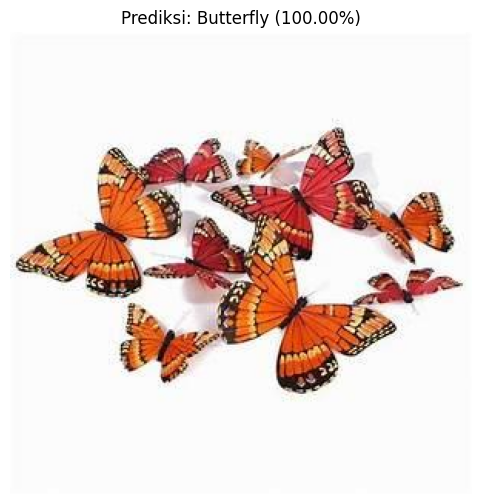

In [8]:
# --- 1. Load Model Terbaik ---
try:
    saved_model = keras.models.load_model('transfer_learning_best.keras')
    print("Model 'transfer_learning_best.keras' berhasil dimuat.")
except Exception as e:
    print(f"Error saat memuat model: {e}")

# --- 2. Siapkan Gambar Lokal ---
local_image_path = '/kaggle/working/animals10/raw-img/Butterfly/image_1.jpg'
try:
    img = Image.open(local_image_path).convert("RGB")
    print(f"Gambar berhasil dimuat dari: {local_image_path}")
except FileNotFoundError:
    print(f"Error: File tidak ditemukan di {local_image_path}")
    img = None

# --- 3. Preprocessing Gambar ---
if img:
    img_resized = img.resize(IMG_SIZE) # Pastikan IMG_SIZE sudah terdefinisi
    img_array = keras.utils.img_to_array(img_resized)
    img_array = tf.expand_dims(img_array, 0)

    # Preprocessing yang sama dengan saat training
    processed_img_array = preprocess_input(img_array)

    # --- 4. Lakukan Prediksi ---
    predictions = saved_model.predict(processed_img_array)
    
    # --- 5. Tampilkan Hasil ---
    # Tidak perlu softmax lagi karena output model sudah berupa probabilitas
    score = predictions[0]
    predicted_class = class_names[np.argmax(score)] # Pastikan class_names sudah terdefinisi
    confidence = 100 * np.max(score)

    print(f"\nModel memprediksi gambar ini sebagai: {predicted_class}")
    print(f"Dengan tingkat keyakinan: {confidence:.2f}%")

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()